In [433]:
data_dir = "."

In [434]:
import os

In [435]:
# #prefix = "MA8_"
# #for file in os.listdir(data_dir):
#     if file.startswith(prefix):
#         new_filename = file[len(prefix):]
#         os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [436]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [437]:
import muon as mu

In [438]:
mdata = mu.read_10x_h5('/Users/pfb2024/pfb_project/PFB-LOLA-seq/featured_feature_bc_matrix.h5')

/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /Users/pfb2024/pfb_project/PFB-LOLA-seq/featured_feature_bc_matrix.h5


/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Located fragments file: /Users/pfb2024/pfb_project/PFB-LOLA-seq/atac_fragments.tsv.gz


/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [439]:
mdata.var_names_make_unique()
mdata

MuData object with n_obs × n_vars = 5059 × 109696
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	5059 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	5059 x 73095
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'files'

In [440]:
from muon import atac as ac

In [441]:
rna = mdata.mod['rna']

In [442]:
rna

AnnData object with n_obs × n_vars = 5059 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [443]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

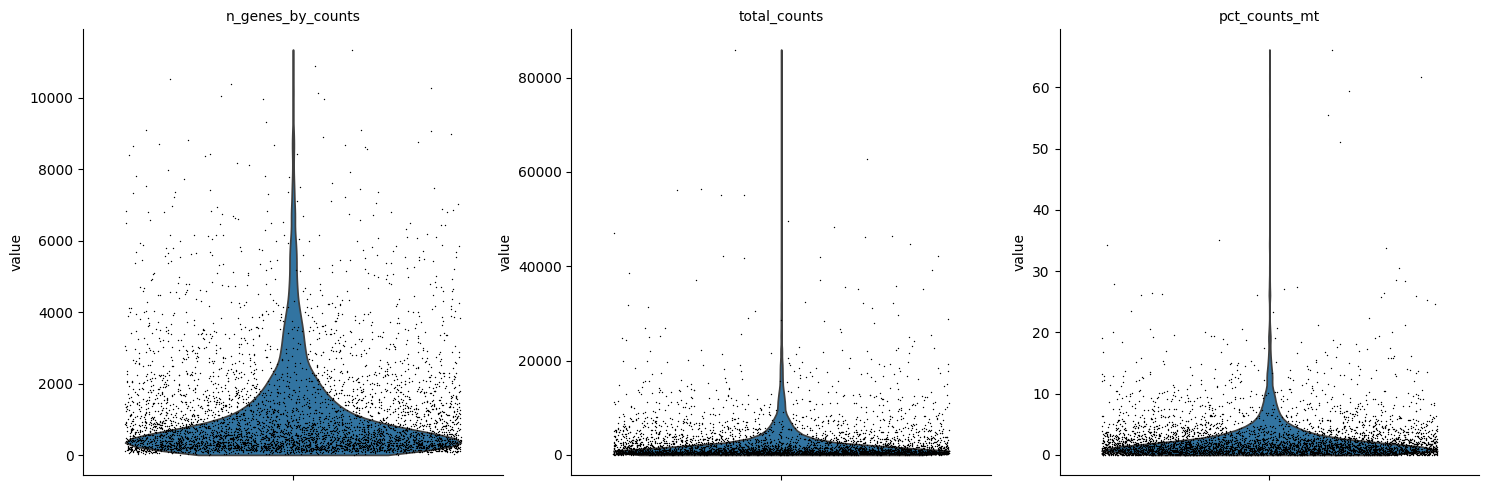

In [444]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [445]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object

In [446]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 4000))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

#mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 25000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 25)

In [447]:
#Here's calculating percent ribo genes
ribo_genes = rna.var_names.str.startswith(("RPS","RPL"))
print(sum(ribo_genes))
rna.obs['percent_ribo'] = np.sum(rna[:, ribo_genes].X, axis=1).A1 / np.sum(rna.X, axis=1).A1

98


In [448]:
# filter for percent ribo > 0.05
rna = rna[rna.obs['percent_ribo'] < 0.05, :]

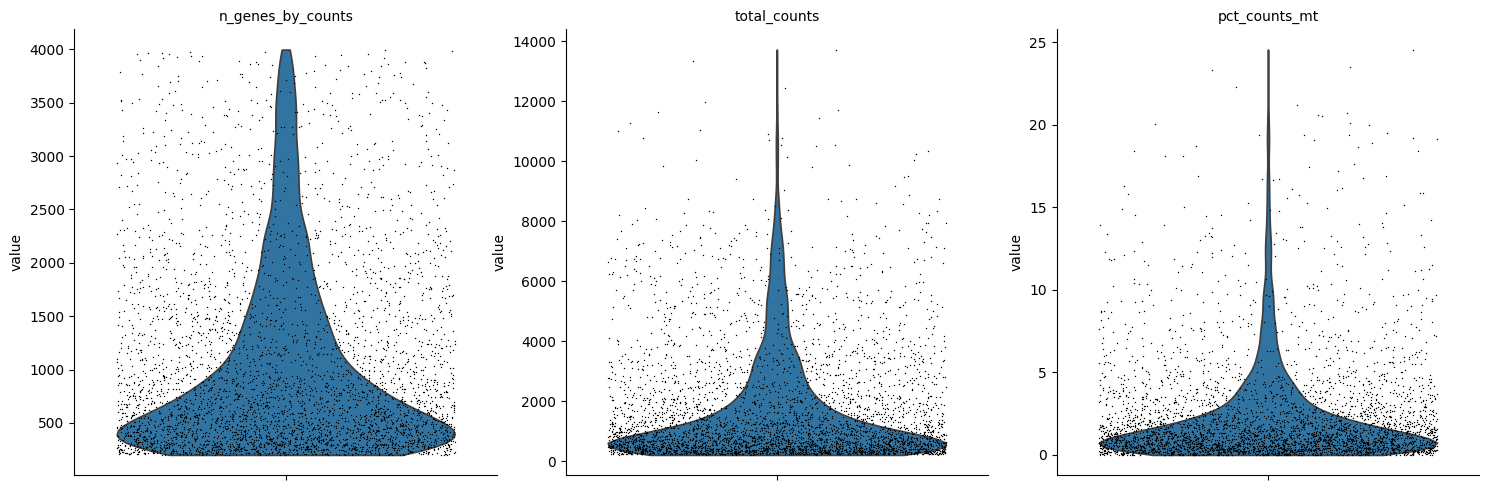

In [449]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [450]:
#Normalization

In [451]:
sc.pp.normalize_total(rna, target_sum=1e4)

/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [452]:
sc.pp.log1p(rna)

In [453]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

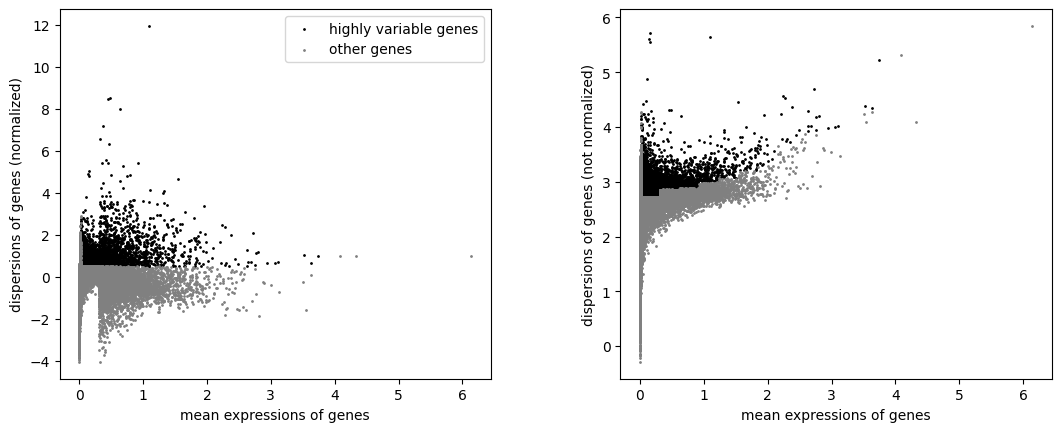

In [454]:
sc.pl.highly_variable_genes(rna)

In [455]:
np.sum(rna.var.highly_variable)

np.int64(6340)

In [456]:
#Scaling

In [457]:
rna.raw = rna

In [458]:
sc.pp.scale(rna, max_value=10)

In [459]:
#Analysis

In [460]:
#PCA and neighbourhood graph

In [461]:
sc.tl.pca(rna)

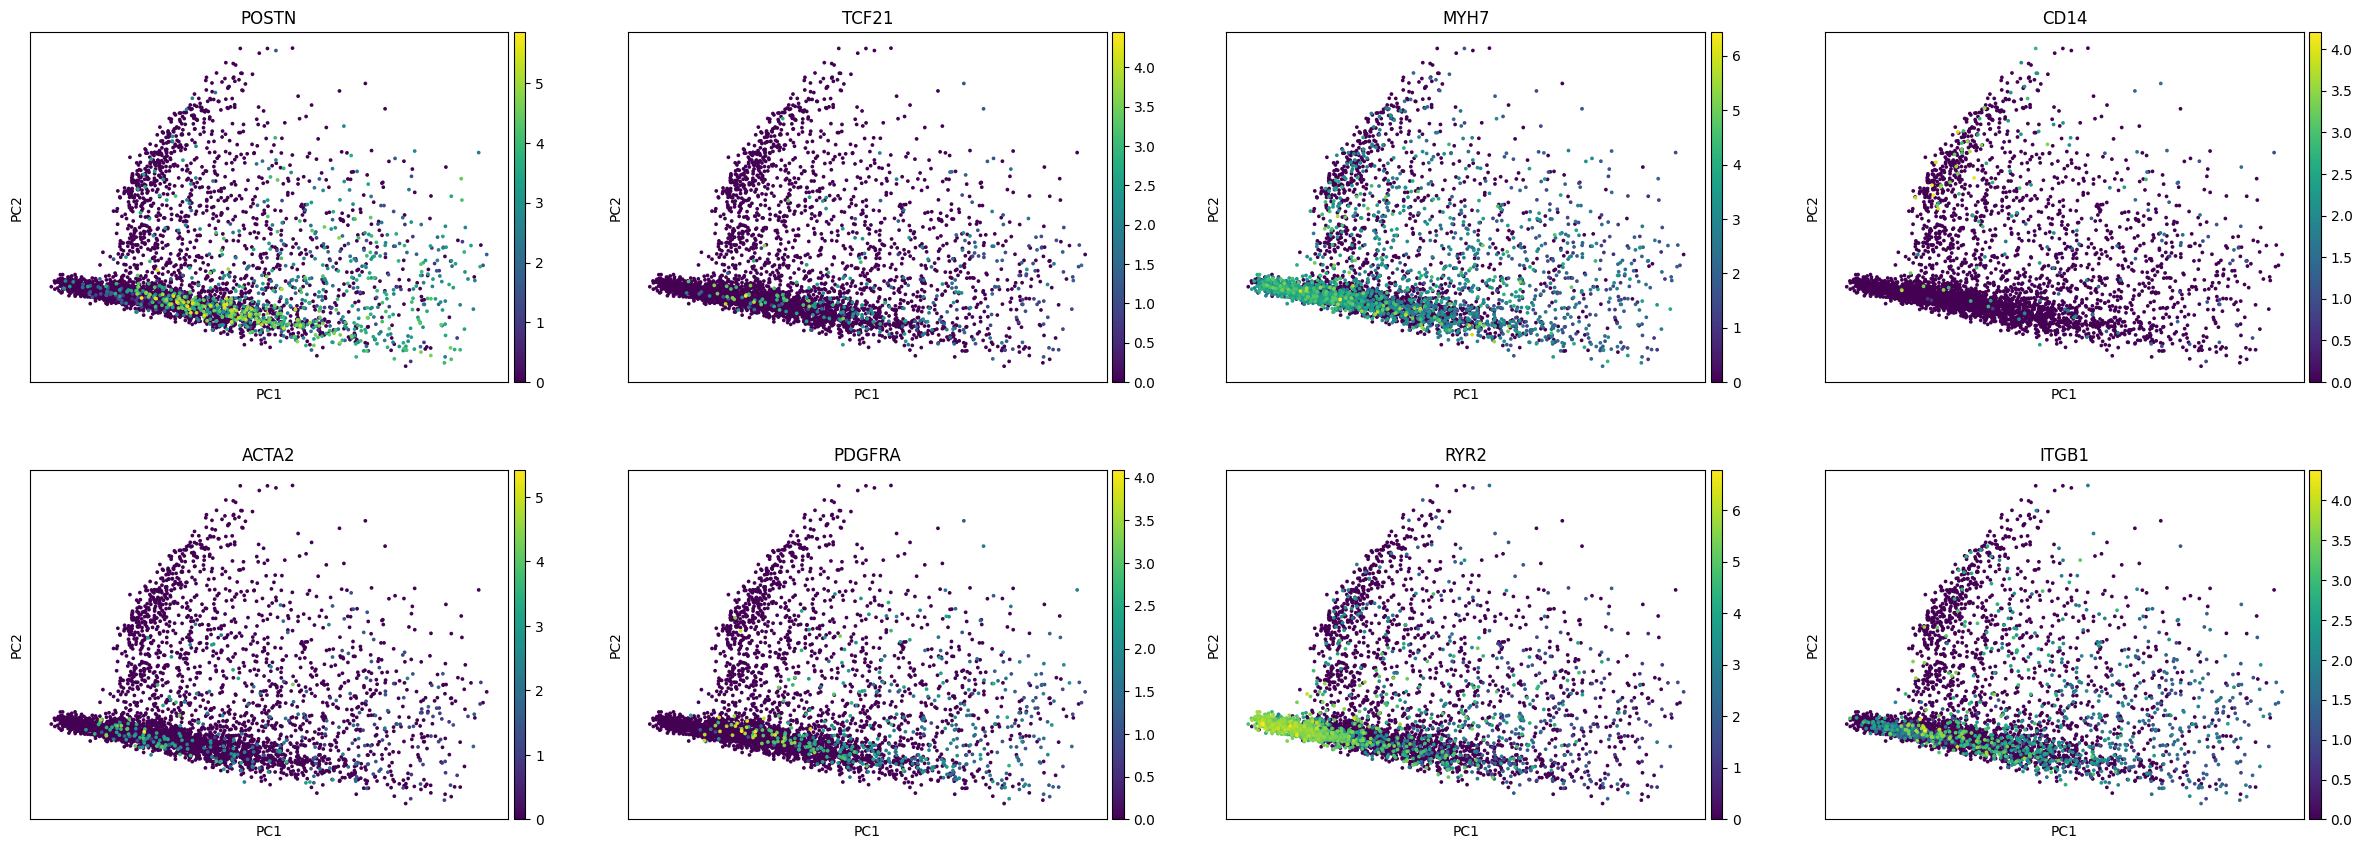

In [462]:
sc.pl.pca(rna, color=['POSTN', 'TCF21', 'MYH7', 'CD14', 'ACTA2', 'PDGFRA', 'RYR2', 'ITGB1'])

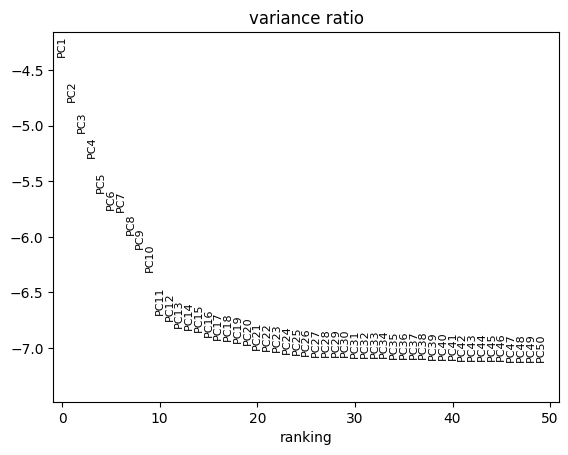

In [463]:
sc.pl.pca_variance_ratio(rna, n_pcs=50, log=True)

In [464]:
sc.pp.neighbors(rna)

In [465]:
#Non-linear dimensionality reduction and clustering

In [466]:
sc.tl.umap(rna)

In [467]:
sc.tl.leiden(rna)

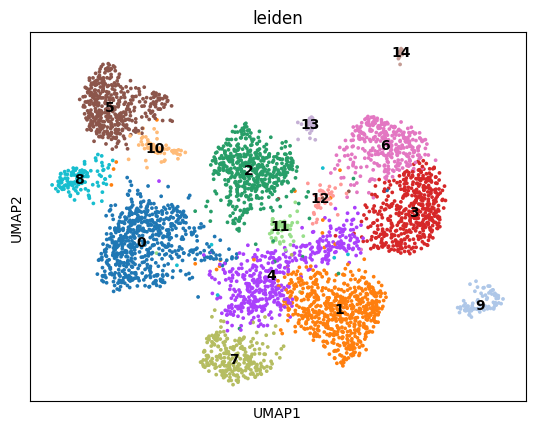

In [468]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

In [469]:
marker_genes = ["MYH7", "MYH6", "NPPA", "NPPB", "TTN", "RYR2",
                'ITGB1',
                "PDGFRA", "TCF21", "POSTN", "FAP","ACTA2",
                "FCN1", "CD14",
                "TCF7L2", "FCGR3A", "LYN",
                "FOLR2", "TIMD4", "CD163", "LYVE1"]

In [470]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

KeyError: 'rank_genes_groups'

In [471]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

KeyError: 'rank_genes_groups'

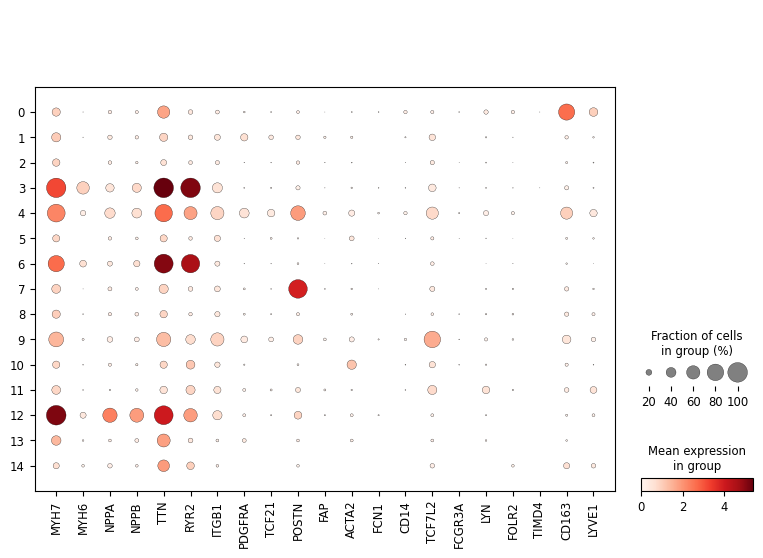

In [472]:
sc.pl.dotplot(rna, marker_genes, groupby='leiden');

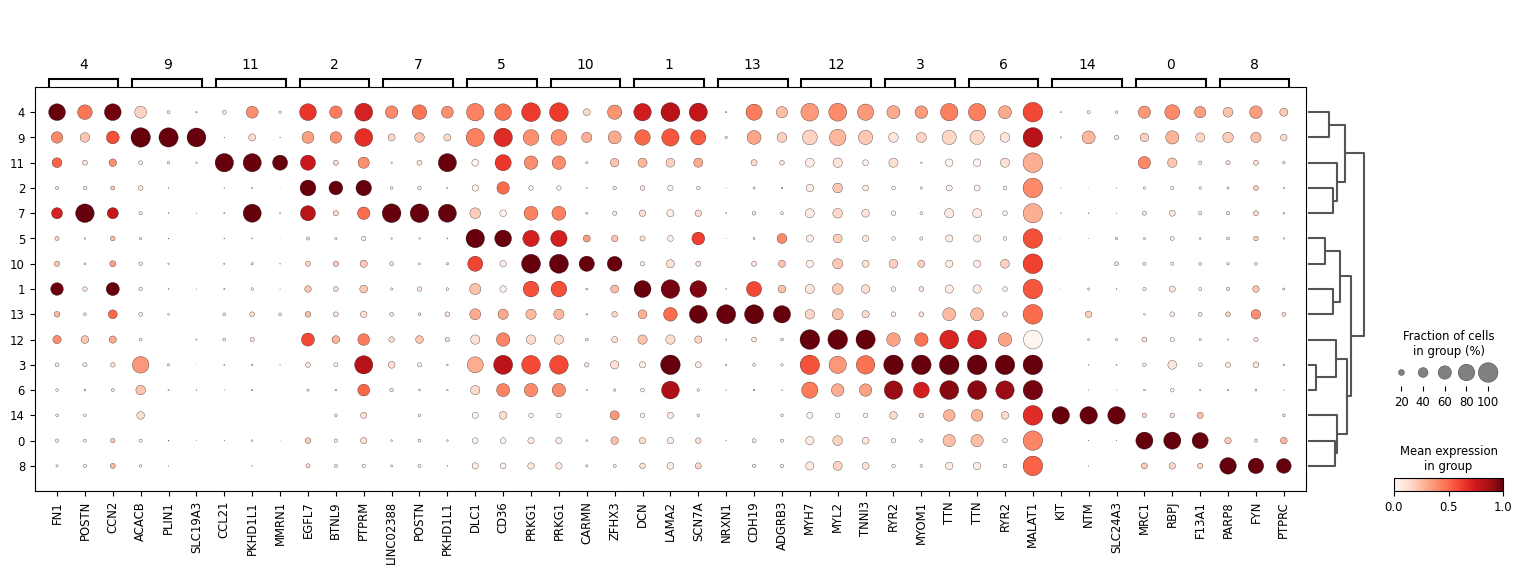

In [473]:
sc.tl.rank_genes_groups(rna, groupby="leiden", method="wilcoxon", n_genes = 40)
sc.pl.rank_genes_groups_dotplot(rna, groupby='leiden', n_genes=3, standard_scale="var");

In [474]:
mdata.write("/Users/pfb2024/pfb_project/PFB-LOLA-seq/MA8.h5mu")

/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [475]:
######## ATAC Modality

In [476]:
mdata1 = mu.read("/Users/pfb2024/pfb_project/PFB-LOLA-seq/MA8.h5mu/")

/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [477]:
mdata1

MuData object with n_obs × n_vars = 5059 × 96938
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	4132 x 23843
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'percent_ribo'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    atac:	5059 x 73095
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'files'

In [478]:
atac = mdata1.mod['atac']

In [479]:
atac.X.shape

(5059, 73095)

In [480]:
#QC

In [481]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

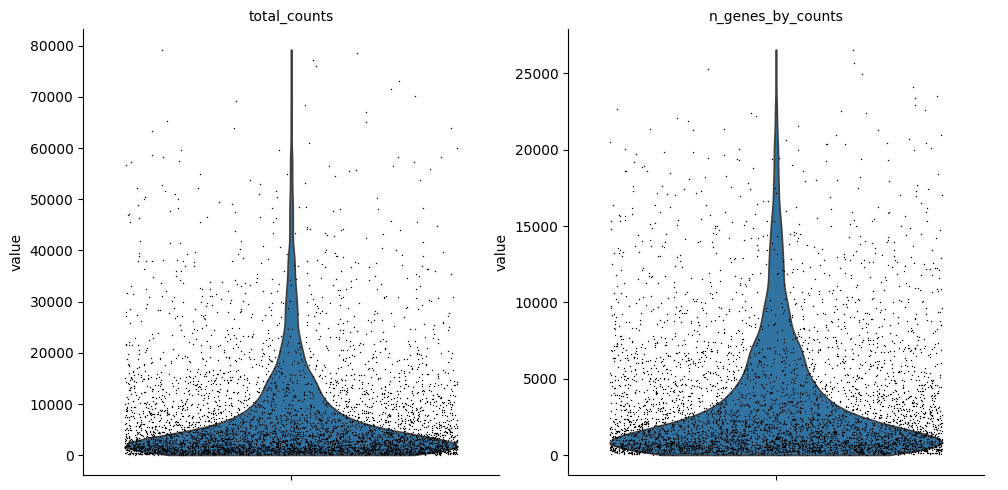

In [482]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [485]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 3)

In [486]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 200) & (x <= 4000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

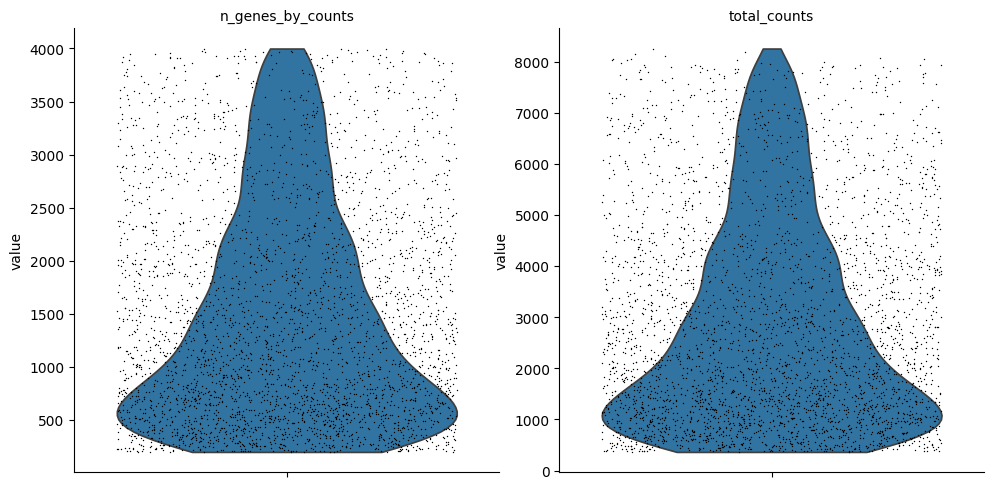

In [487]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

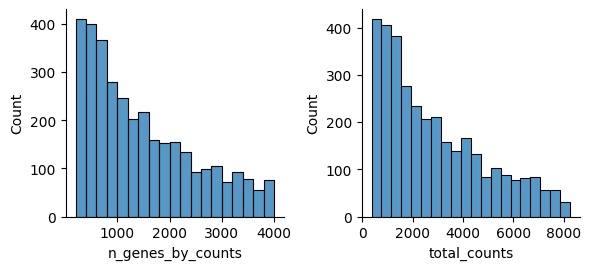

In [488]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

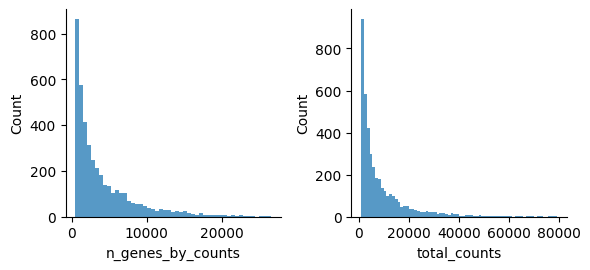

In [405]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

In [ ]:
#ATAC specific QC

In [489]:
atac.obs['NS']=1

Fetching Regions...: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


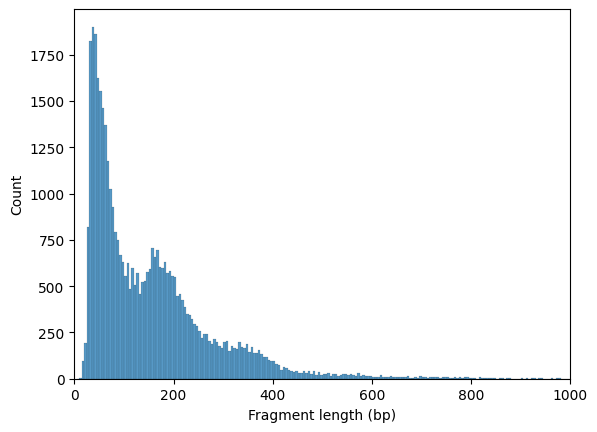

In [490]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [492]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:03<00:00, 294144.47it/s]


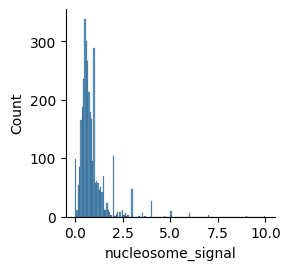

In [493]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

In [ ]:
#TSS enrichment

In [494]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL669831.2,chr1,760910,760911,ENSG00000229905,AL669831.2


In [495]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|██████████| 1000/1000 [00:06<00:00, 157.86it/s]
/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [496]:
tss

AnnData object with n_obs × n_vars = 5059 × 2001
    obs: 'tss_score'
    var: 'TSS_position'

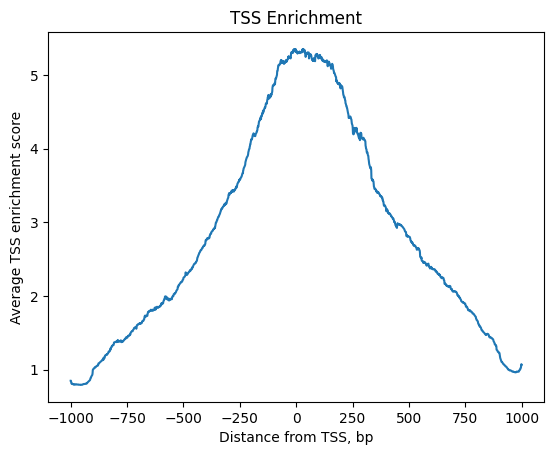

In [497]:
ac.pl.tss_enrichment(tss)

In [ ]:
#Normalisation

In [498]:
# Save original counts
atac.layers["counts"] = atac.X

In [501]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

In [ ]:
#Feature selection 
#We will label highly variable peaks that we’ll use for downstream analysis.

In [502]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

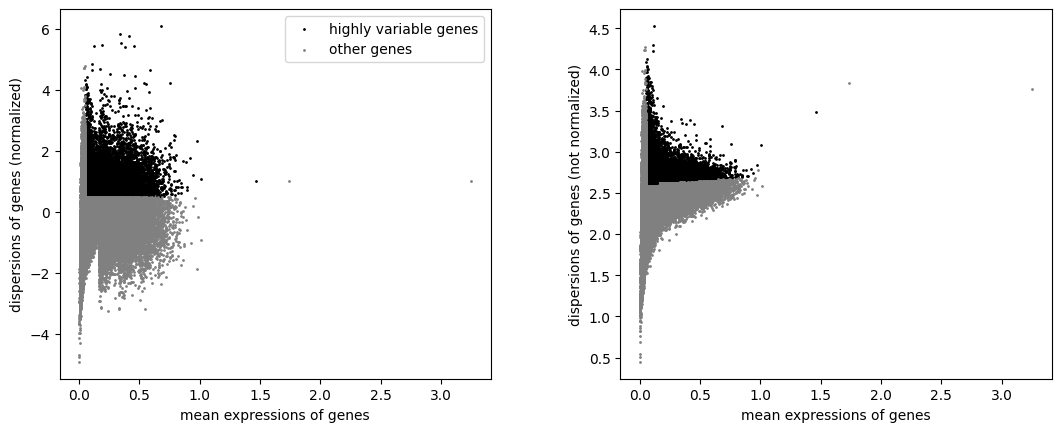

In [503]:
sc.pl.highly_variable_genes(atac)

In [504]:
np.sum(atac.var.highly_variable)

np.int64(15752)

In [ ]:
#Scaling

In [ ]:
#TF-IDF normalization did not work previously but this step does TF-IDF counts for getting latent components. Apparenlty , this works!

In [505]:
atac.raw = atac

In [506]:
ac.tl.lsi(atac)

In [507]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [508]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [ ]:
#PCA plots ATAC

In [509]:
sc.pp.scale(atac)
sc.tl.pca(atac)

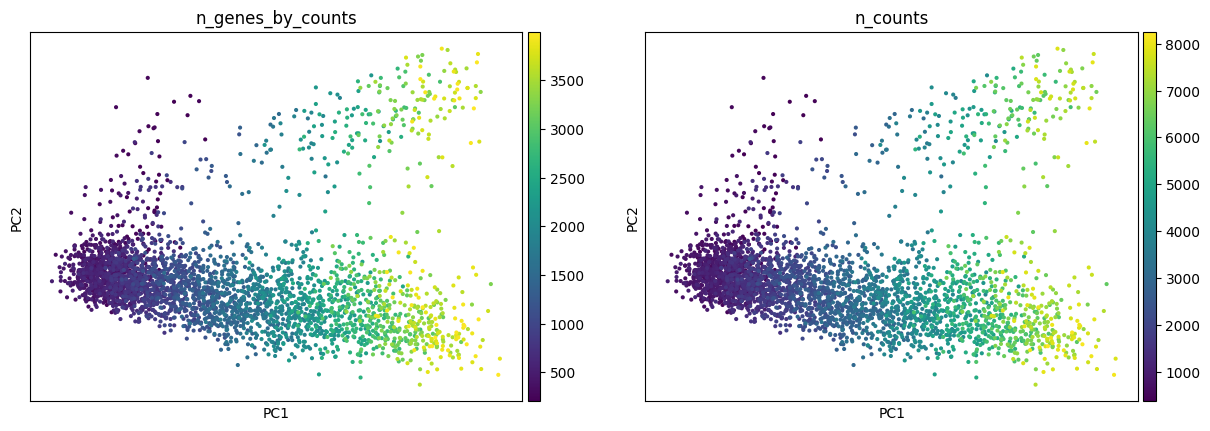

In [510]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

In [516]:
ac.tl.add_peak_annotation(atac, annotation="/Users/pfb2024/pfb_project/PFB-LOLA-seq/atac_peak_annotation.tsv")

/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/muon/_atac/tools.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pa.loc[pa.distance.isnull(), "distance"] = ""


In [517]:
atac.uns['atac']['peak_annotation'].tail()

,peak,distance,peak_type
gene,,,
VAMP7,chrY:56876314-56876418,191447,distal
VAMP7,chrY:56877388-56877968,189897,distal
VAMP7,chrY:56879537-56880497,187368,distal
VAMP7,chrY:56881488-56881665,186200,distal
VAMP7,chrY:56885563-56885700,182165,distal


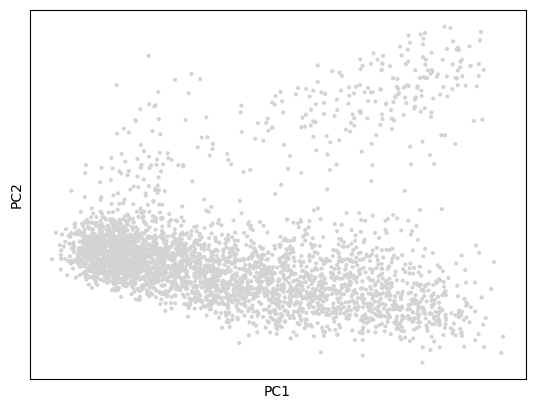

In [526]:
ac.pl.pca(atac, color=None, average="total")

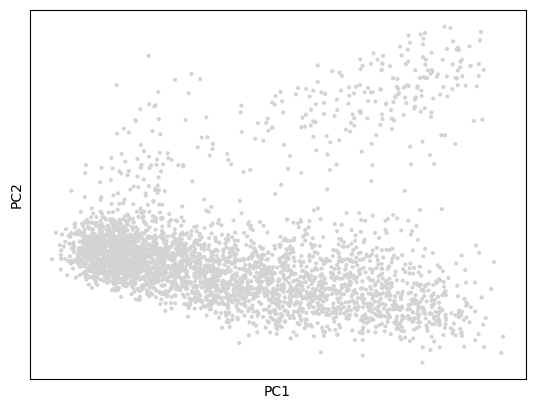

In [530]:
ac.pl.pca(atac, color=None, average="peak_type")

In [531]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

In [ ]:
#Non-linear dimensionality reduciton and clustering

In [532]:
sc.tl.leiden(atac, resolution=.5)

In [533]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

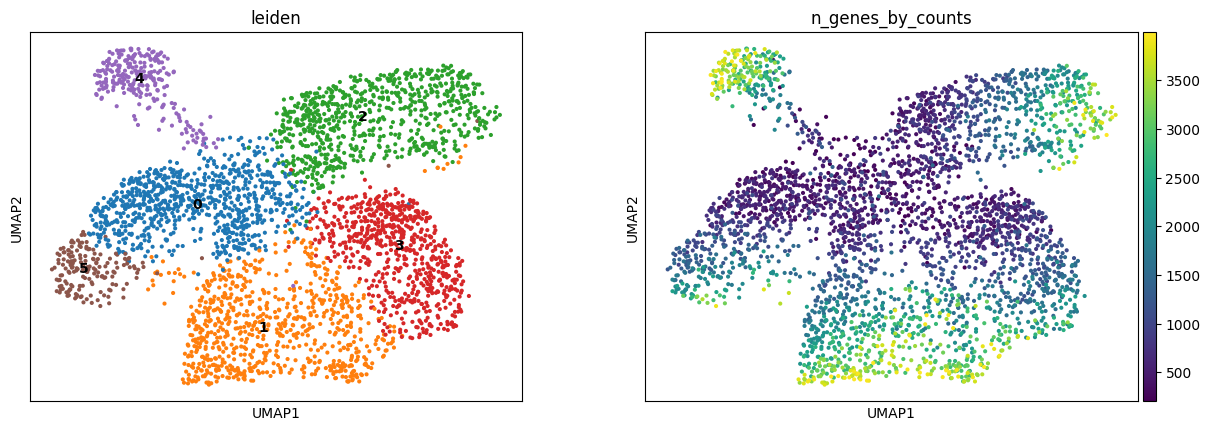

In [534]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

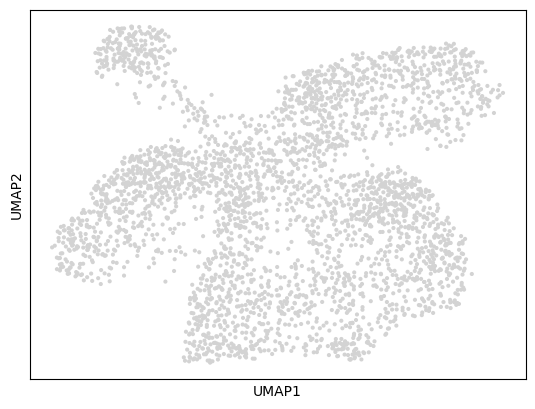

In [542]:
ac.pl.umap(atac, color=None, average="peak_type")

In [ ]:
#Marker genes and cell types

In [543]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [546]:
result1 = atac.uns['rank_genes_groups']
groups1 = result1['names'].dtype.names
pd.set_option("max_columns", 50)
pd.DataFrame(
    {group + '_' + key[:1]: result1[key][group]
    for group in groups1 for key in ['names', 'genes', 'pvals']}).head(10)

OptionError: Pattern matched multiple keys

In [198]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [199]:
atac.X.shape

(5059, 73095)

In [200]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
print(f"(After total_counts: {atac.n_obs} cells)")
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))
print(f"After: {atac.n_obs} cells")

Before: 5059 cells
(After total_counts: 4175 cells)
After: 4175 cells


In [201]:
atac.X.shape

(4175, 73095)

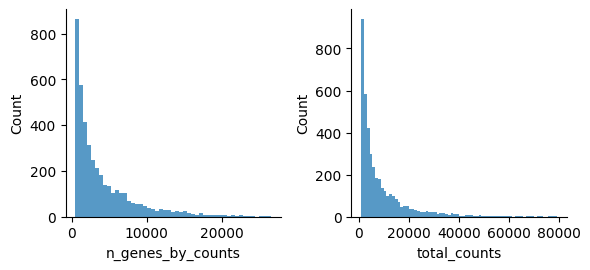

In [202]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

Fetching Regions...: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


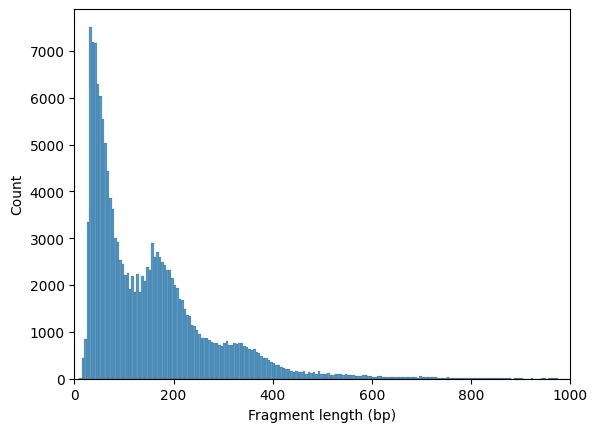

In [203]:
#atac.uns
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [204]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:03<00:00, 291061.67it/s]


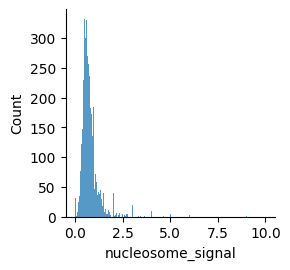

In [205]:
mu.pl.histogram(atac, "nucleosome_signal", linewidth=0)

In [206]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(20)

,Chromosome,Start,End,gene_id,gene_name
MIR1302-2HG,chr1,29553,30267,ENSG00000243485,MIR1302-2HG
FAM138A,chr1,36080,36081,ENSG00000237613,FAM138A
OR4F5,chr1,65418,69055,ENSG00000186092,OR4F5
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.3,chr1,91104,91105,ENSG00000239945,AL627309.3
AL627309.2,chr1,140338,140339,ENSG00000239906,AL627309.2
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL627309.4,chr1,160445,160446,ENSG00000241599,AL627309.4
AP006222.2,chr1,266854,266855,ENSG00000286448,AP006222.2
AL732372.1,chr1,360056,360057,ENSG00000236601,AL732372.1


In [207]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)

Fetching Regions...: 100%|██████████| 1000/1000 [00:04<00:00, 200.95it/s]
/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [208]:
tss

AnnData object with n_obs × n_vars = 4175 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

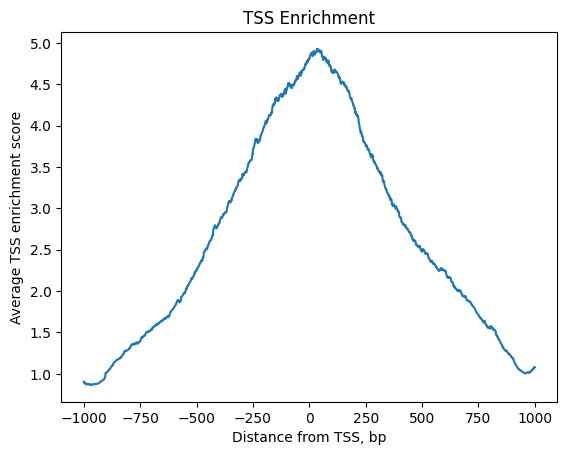

In [209]:
ac.pl.tss_enrichment(tss)

In [211]:
atac.layers["counts"] = atac.X
ac.pp.tfidf(atac, scale_factor=1e4)

ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

In [ ]:
#sc.pp.normalize_total(atac, target_sum=1e4)
#sc.pp.log1p(atac)
#atac.layers["lognorm"] = atac.X.copy()

In [156]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

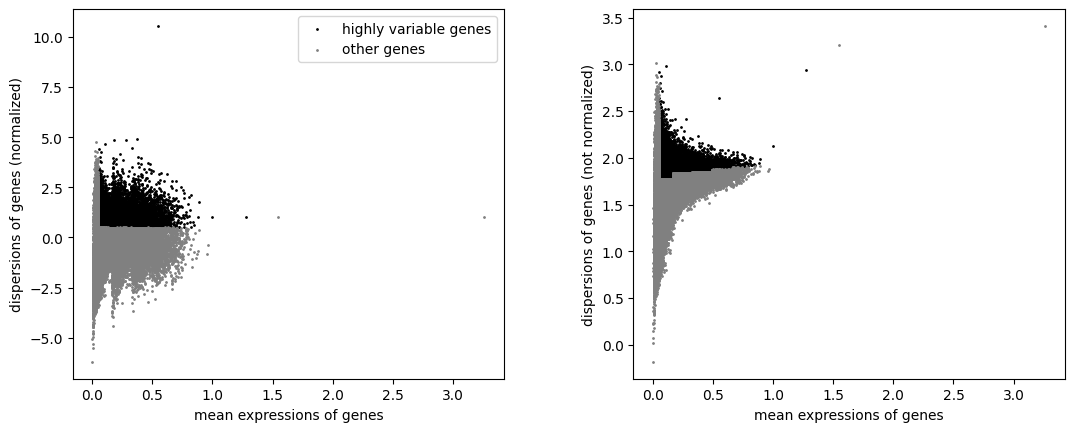

In [157]:
sc.pl.highly_variable_genes(atac)

In [158]:
np.sum(atac.var.highly_variable)

np.int64(15638)

In [159]:
sc.pp.scale(atac, max_value=10)
sc.tl.pca(atac)

KeyError: 'There is no feature or feature annotation FAM138A. If it is a gene name, load peak annotation with muon.atac.pp.add_peak_annotation first.'

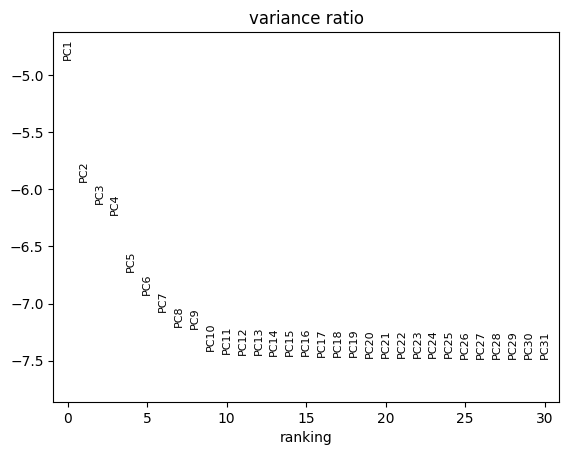

In [175]:
sc.pl.pca_variance_ratio(atac, log=True)

In [176]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)

In [177]:
sc.tl.leiden(atac, resolution=.5)

/var/folders/j0/6b9x3l9n5nzgmbj9pcz255xc0000gq/T/ipykernel_11788/937485634.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=.5)


In [178]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)

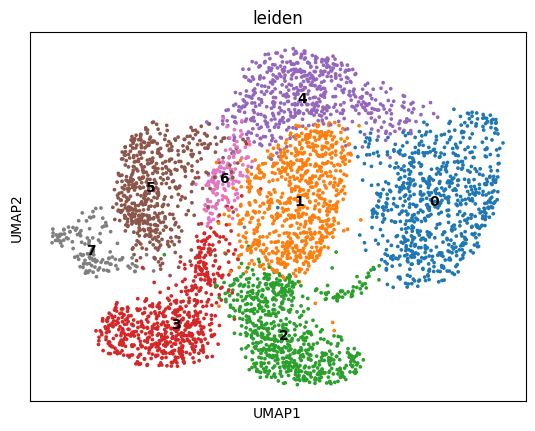

In [179]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

In [180]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib

KeyError: 'There is no peak annotation yet. Run muon.atac.pp.add_peak_annotation first.'

In [37]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

In [38]:
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(5)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,...,15_p,16_n,16_g,16_p,17_n,17_g,17_p,18_n,18_g,18_p
0,chr9:107480158-107492721,KLF4,0.0,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",2.006806e-283,chr2:86783559-86792275,CD8A,7.605271e-318,chr14:99255246-99275454,...,0.000002,chr16:81519063-81525049,CMIP,8.111361e-20,chr16:88448143-88480965,ZFPM1,4.322022e-10,chr19:21593423-21595308,AC123912.2,1.085685e-07
1,chr11:61953652-61974246,"BEST1, FTH1",0.0,chr14:99255246-99275454,"BCL11B, AL109767.1",1.029193e-187,chr14:99255246-99275454,"BCL11B, AL109767.1",7.116866e-273,chr14:99223600-99254668,...,0.000011,chr17:40536232-40543738,CCR7,8.654992e-20,chr5:35850992-35860227,IL7R,7.201006e-08,chr14:75267507-75300328,"FOS, AL691403.1, AF111167.1, LINC01220",2.915830e-06
2,chr1:212604203-212626574,"FAM71A, ATF3, AL590648.2",0.0,chr10:8041366-8062418,"GATA3, GATA3-AS1, AL390294.1",1.957144e-170,chr11:66311352-66319301,"CD248, AP001107.3",2.546002e-258,chr14:99181080-99219442,...,0.000014,chr22:44709028-44711972,PRR5,1.233009e-19,chr22:39087900-39092994,APOBEC3H,1.269553e-07,chr3:128485776-128493826,"GATA2, GATA2-AS1",3.350269e-06
3,chr19:13824929-13854962,"ZSWIM4, AC020916.1",0.0,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",8.145375e-166,chr12:10552886-10555668,LINC02446,1.832240e-212,chr7:142782798-142813716,...,0.000016,chr2:29009215-29017012,TOGARAM2,1.167899e-19,chr14:105856766-105860740,IGHM,9.403634e-07,chr21:44965117-44970844,"FAM207A, AP001505.1",5.249908e-06
4,chr7:106256272-106286624,"NAMPT, AC007032.1",0.0,chr14:99223600-99254668,"BCL11B, AL109767.1",3.331213e-154,chr2:136122469-136138482,CXCR4,3.153676e-229,chr14:22536559-22563070,...,0.000018,chr11:114065160-114066911,ZBTB16,1.896234e-19,chr5:178112840-178119590,N4BP3,1.103862e-06,chr17:82211956-82220400,"CCDC57, AC132872.2",6.219738e-06


In [39]:
#mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["9"]))
atac1 = atac[~atac.obs.leiden.isin(["10", "14", "15", "16"])]

In [40]:
atac.n_obs

11564

In [41]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "OPC",
    "7": "microglia",
    "2": "astrocyte",
    "8": "astrocyte",
    "4": "excitatory",
    "5": "inhibitory1",
    "6": "inhibitory2",
}

In [42]:
atac.obs['celltype'] = [new_cluster_names[cl] for cl in atac.obs.leiden.astype("str").values]
atac.obs.celltype = atac.obs.celltype.astype("category")

KeyError: '14'